# Functions Concept

https://www.alanzucconi.com/2015/09/30/colour-sorting/

Steps
1. Sort and take position of values
2. Bin the values
3. Within each bin find the mode value and calculate difference of remaining value to the mode 
4. Apply to new value (New Value - Difference) i.e. 0=new value, 1=1+new value, ...
5. Flatten
6. Return to original order (using position values array)


Possible issues:
* When calculating the difference array, some values may be calculated as new values from other bins
    - results in a loss of colours
    - possible solution: return a value between these 2 numbers or half the step value

## Setup

In [1]:
from PIL import ImageColor
import random
import matplotlib.pyplot as plt
import colorsys
import math
import copy
import numpy as np
from scipy import stats

plt.rcParams['figure.figsize'] = [15, 5]

def showImage(image):
    plt.imshow(image)
    plt.show() 

def hexToRGB(hexcode):
    return ImageColor.getcolor(hexcode, "RGB")

def rgbToHex(rgb):
    return '#%02x%02x%02x' % tuple(rgb)

Colour array

In [2]:
random.seed(123)
colours_length = 50
colours = []
for i in range(1, colours_length):
    colours.append (
        [
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255)
        ]
    )

new hex values array

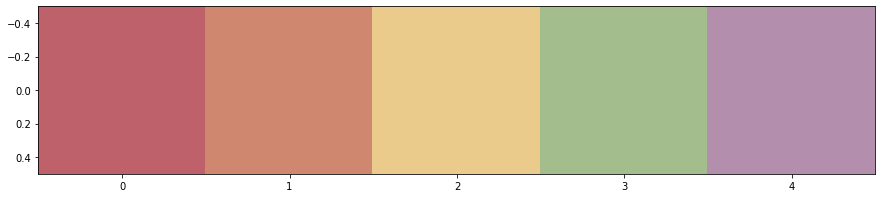

In [3]:
nord_aurora_hex = ["#bf616a", "#d08770", "#ebcb8b", "#a3be8c", "#b48ead"]
nord_aurora_RGB = [hexToRGB(i) for i in nord_aurora_hex]

showImage([nord_aurora_RGB])

## 1.1. Deep copy of original array
Make a deep copy to later get the correct ordr

In [4]:
og_colours = copy.deepcopy(colours)

## 1.2. Sort values 

based on https://www.alanzucconi.com/2015/09/30/colour-sorting/

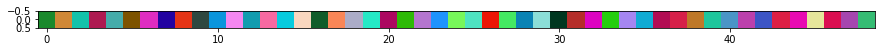

In [5]:
showImage([colours])

In [6]:
def step(r,g,b, repetitions=1):
    lum = math.sqrt( .241 * r + .691 * g + .068 * b )

    h, s, v = colorsys.rgb_to_hsv(r,g,b)

    h2 = int(h * repetitions)
    lum2 = int(lum * repetitions)
    v2 = int(v * repetitions)

    if h2 % 2 == 1:
        v2 = repetitions - v2
        lum = repetitions - lum

    return (h2, lum, v2)


OG order


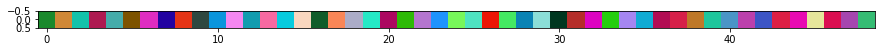

sorted


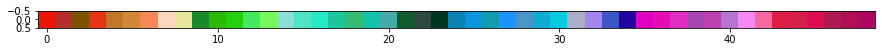

In [16]:
#Sort with step function
colours.sort(key=lambda rgb: step(rgb[0],rgb[1],rgb[2],8)) 

print("OG order")
showImage([og_colours])
print("sorted")
showImage([colours])

## 1.3 Determine the order
* create an list of the original index in the order of the newly sorted list
* by comparing the original with the sorted list
* create a `None` array to help with the occurance of non-unique values - as their positions should be unique!


In [18]:
def returnCompareListsReturnIndex(original, arranged):

    size = len(original)
    store_pos_None = [None]* len(original)

    for n in range(0, size):
        elem = original[n]
        pos = [i for i, x in enumerate(arranged) if x == elem]

        if len(pos) <= 1:
            # when only 1 instance is present
            store_pos_None[n] = pos[0]
        else:
            # multiple posible positions
            for i in pos:
                if store_pos_None[n] is None and i not in store_pos_None:
                    # position must not already be filled and index not already present 
                        store_pos_None[n] = i
    
    return store_pos_None


def rearrange(arranged, indexList):
    return [arranged[i] for i in indexList]


original = [6, 8, 9, 10, 1, 2, 7, 3, 4, 5]
arranged = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#original = [3, 2, 3, 1, 3]
#arranged = [1, 2, 3, 3, 3]

indexList = returnCompareListsReturnIndex(original, arranged)

rearrange_list = rearrange(arranged, indexList)

print(original)
print(rearrange_list)


[6, 8, 9, 10, 1, 2, 7, 3, 4, 5]
[6, 8, 9, 10, 1, 2, 7, 3, 4, 5]


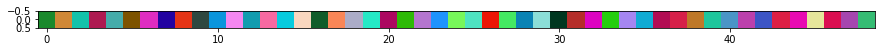

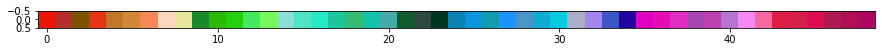

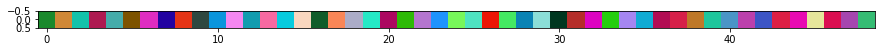

In [28]:
indexList = returnCompareListsReturnIndex(og_colours, colours)
rearrange_list = rearrange(colours, indexList)

showImage([og_colours])
showImage([colours])
showImage([rearrange_list])


# seems to work...

## 2. Bin the values

In [9]:
nThemeColours = len(nord_aurora_RGB)
binnedData = np.array_split(colours, nThemeColours)

### 3.1. Within each bin find the mode value 

In [10]:
def getRoughMiddle(arr):
    halfway = round(len(arr)/2)-1
    return [arr[halfway]]

def modeRGBInBinnedArray(binnedData):
    store = []
    for bin_element in binnedData:

        hexBinnedData = [rgbToHex(i) for i in bin_element]
        hexMode, hexModeCount = stats.mode(hexBinnedData)

        # when there is no mode return the middle of the bin (as they are already sorted)
        if hexModeCount == 1:
            hexMode = getRoughMiddle(hexBinnedData)

        # convert back to RGB
        hexMode = list(hexToRGB(hexMode[0]))
        
        store.append(hexMode)
    return store
        
modeColours = modeRGBInBinnedArray(binnedData)
modeColours

[[190, 120, 40], [139, 222, 215], [10, 131, 180], [35, 3, 161], [221, 31, 69]]

### 3.2 and calculate difference of remaining value to the mode 

In [11]:
# lengths should be the same
#if len(binnedData) == len(modeColours):
#    print("continue!!")
#else:
#    print("incorrect number of mode values")


In [12]:
def adjustArrayToTheme(binnedDataElement, modeRGB, theme_RGB):
    
    diffArray = binnedDataElement - modeRGB
    theme_adjust = diffArray + theme_RGB

    # correct for negative values
    theme_adjust[theme_adjust < 0] = 0
    theme_adjust[theme_adjust > 255] = 255

    return theme_adjust

def returnAdjustedBinnedData(binnedData, modeColours, theme_RGB):
    store = []
    for i in range(0, len(binnedData)):
        adjustedBin = adjustArrayToTheme(binnedData[i], modeColours[i], theme_RGB[i])
        store.append(adjustedBin)

    return store


adjustedThemeBinnedData = returnAdjustedBinnedData(binnedData, modeColours, nord_aurora_RGB)
adjustedThemeBinnedData

[array([[237,   0,  71],
        [182,  22, 108],
        [126,  60,  66],
        [230,  29,  88],
        [191,  97, 106],
        [209, 113, 121],
        [250, 111, 153],
        [249, 191, 255],
        [231, 207, 221],
        [ 27, 114, 110]]),
 array([[114,  99,   0],
        [106, 119,   0],
        [137, 146,   0],
        [188, 160,   0],
        [208, 135, 112],
        [147, 140,  90],
        [106, 146,  95],
        [ 98, 111,  53],
        [122, 101,  12],
        [ 88, 107,  67]]),
 array([[255, 244, 129],
        [241, 164,   1],
        [255, 144,  23],
        [225, 127,   0],
        [235, 203, 139],
        [235, 221, 179],
        [243, 228, 134],
        [255, 219, 212],
        [255, 221, 158],
        [241, 243, 171]]),
 array([[134, 255, 201],
        [255, 255, 179],
        [255, 255, 220],
        [189, 255, 176],
        [163, 190, 140],
        [255, 191, 172],
        [255, 197, 157],
        [255, 231, 172],
        [255, 255, 154],
        [255, 251, 

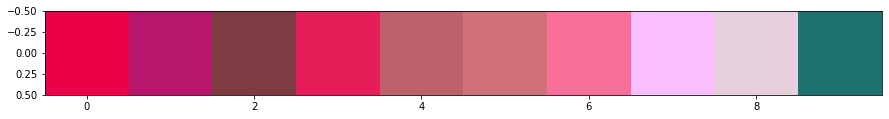

In [13]:
showImage([adjustedThemeBinnedData[0]])

## 5. flattern

In [14]:
flat_colour_list = [list(item) for sublist in adjustedThemeBinnedData for item in sublist]

original


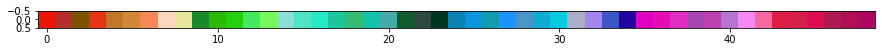

adjusted with


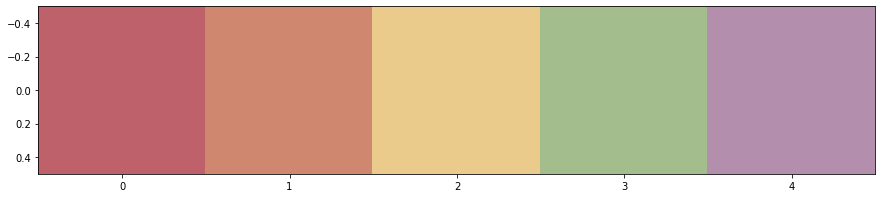

result


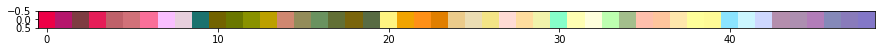

In [15]:
print("original")
showImage([colours])
print("adjusted with")
showImage([nord_aurora_RGB])
print("result")
showImage([flat_colour_list])

## 6. Return to original order


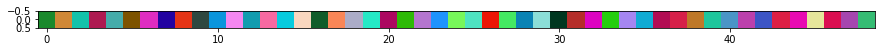

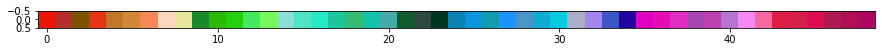

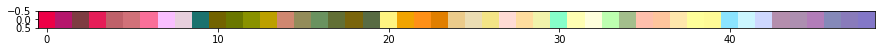

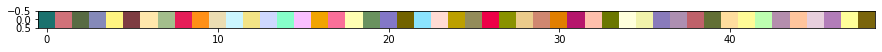

In [31]:
indexList = returnCompareListsReturnIndex(og_colours, colours)
rearrange_list = rearrange(flat_colour_list, indexList)

showImage([og_colours])
showImage([colours])
showImage([flat_colour_list])
showImage([rearrange_list])
